In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression

import re
import csv
from tqdm import tqdm


## Read the Data

In [18]:
data = "train_data.csv"
df1 = pd.read_csv(data)

## Data Preprocessing

In [19]:
#Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)


## Data Preprocessing

In [20]:
data = "train_data.csv"
df1 = pd.read_csv(data)

#Prepare card id and ip id for plotting

# # 1.Card ID
# card_enc = LabelBinarizer()
# df1['card_id'] = card_enc.fit_transform(df1[])

#
# # 2.IP ID
# ip_enc = LabelBinarizer()
# df1['ip_id'] = ip_enc.fit_transform(df1.ip_id)

#Encoding, Cleaning the data
df1.loc[df1['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df1.loc[df1['issuercountrycode'].isna(),'issuercountrycode'] = 'ZZ'
df1.loc[df1['shoppercountrycode'].isna(),'shoppercountrycode'] = 'ZZ'

#Feature Engineering
df1['countries_equal'] = (df1['shoppercountrycode'] == df1['issuercountrycode'])
df1.loc[df1['countries_equal'] == False,'countries_equal'] = 0
df1.loc[df1['countries_equal'] == True,'countries_equal'] = 1

def conv(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']]*100)

df1['amount_eur'] = df1.apply(lambda x: conv(x), axis=1)

df1['accountcode'] = df1['accountcode'].apply(lambda x: re.sub('Account','',x))
df1['accountcode_cc'] = 0
df1.loc[(df1['accountcode'] == 'UK'),'accountcode_cc'] = 'GB'
df1.loc[(df1['accountcode'] == 'Mexico'),'accountcode_cc'] = 'MX'
df1.loc[(df1['accountcode'] == 'Sweden'),'accountcode_cc'] = 'SE'
df1.loc[(df1['accountcode'] == 'APAC'),'accountcode_cc'] = 'APAC'

df1.loc[df1['mail_id'].str.contains('na',case=False),'mail_id'] = 'email99999'

df1.loc[df1['cvcresponsecode'] > 2,'cvcresponsecode'] = 3

In [21]:
def rank_swapping(data_original, p, num_swaps, columns):
    data = data_original.copy()
    for i, column in enumerate(columns):
        data = data.sort_values(data.columns[column])
        data = data.to_numpy()
        for _ in tqdm(range(num_swaps)):
            swap_index1 = np.random.randint(0, len(data))
            max_index = min(len(data), swap_index1 + p)
            min_index = max(0, swap_index1 - p)
            swap_index2 = np.random.randint(min_index, max_index)
            temp = data[swap_index1][column]
            data[swap_index1][column] = data[swap_index2][column]
            data[swap_index2][column] = temp
        data = pd.DataFrame(data, columns=data_original.columns)

    data = data.sort_values(data.columns[0])
    return data

ranked_frame = rank_swapping(df1, 300, 500000, [1, 4, 5, 6, 16])
original_values = df1.to_numpy()
print(np.equal(ranked_frame, original_values).all())
same_rows = 0
for i in range(len(ranked_frame)):
    if np.equal(ranked_frame.to_numpy()[i], original_values[i]).all():
        same_rows += 1
print('number of rows still the same: ', same_rows)
df1 = ranked_frame

100%|██████████| 500000/500000 [00:03<00:00, 150895.38it/s]


Id                               True
issuercountrycode               False
txvariantcode                    True
bin                              True
amount                          False
currencycode                    False
shoppercountrycode              False
shopperinteraction               True
cardverificationcodesupplied     True
cvcresponsecode                  True
accountcode                      True
mail_id                          True
ip_id                            True
card_id                          True
label                            True
countries_equal                  True
amount_eur                      False
accountcode_cc                   True
dtype: bool
number of rows still the same:  36969


In [22]:
unique_issuer_cc = df1['issuercountrycode'].unique()
unique_shopper_cc = df1['shoppercountrycode'].unique()
both = np.append(unique_issuer_cc, unique_shopper_cc)
df_countrycodes = pd.DataFrame(both)
unique_codes = df_countrycodes[0].unique()
lb = LabelBinarizer()
y = lb.fit_transform(df1['issuercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['issuercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('issuercountrycode', axis=1), df2], axis=1)

y = lb.fit_transform(df1['shoppercountrycode'])

# Create a new DataFrame with the transformed 'issuercountrycode' column
df2 = pd.DataFrame(y, columns=['shoppercountrycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'issuercountrycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shoppercountrycode', axis=1), df2], axis=1)

lb2 = LabelBinarizer()
y = lb2.fit_transform(df1['txvariantcode'])

# Create a new DataFrame with the transformed 'txvariantcode' column
df2 = pd.DataFrame(y, columns=['txvariantcode_'+str(i) for i in range(y.shape[1])])

# Replace the 'txvariantcode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('txvariantcode', axis=1), df2], axis=1)

lb3 = LabelBinarizer()
y = lb3.fit_transform(df1['currencycode'])

# Create a new DataFrame with the transformed 'currencycode' column
df2 = pd.DataFrame(y, columns=['currencycode_'+str(i) for i in range(y.shape[1])])

# Replace the 'currencycode' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('currencycode', axis=1), df2], axis=1)

lb4 = LabelBinarizer()
y = lb4.fit_transform(df1['shopperinteraction'])

# Create a new DataFrame with the transformed 'shopperinteraction' column
df2 = pd.DataFrame(y, columns=['shopperinteraction_'+str(i) for i in range(y.shape[1])])

# Replace the 'shopperinteraction' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('shopperinteraction', axis=1), df2], axis=1)

lb5 = LabelBinarizer()
y = lb5.fit_transform(df1['accountcode_cc'])

# Create a new DataFrame with the transformed 'accountcode_cc' column
df2 = pd.DataFrame(y, columns=['accountcode_cc_'+str(i) for i in range(y.shape[1])])

# Replace the 'accountcode_cc' column in the original DataFrame with the transformed column
df1 = pd.concat([df1.drop('accountcode_cc', axis=1), df2], axis=1)

# drop id, mail_id, ip_id, card_id
df1 = df1.drop(['Id','mail_id','ip_id','card_id', 'amount', 'accountcode'], axis=1)

In [23]:
# Separate features and labels
X = df1.drop('label', axis=1)
y = df1['label']

y = y.astype('int')

# Define the number of folds
n_splits = 3

# Create a StratifiedKFold object
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize accuracy lists to store accuracy for each fold for each classifier
accuracy_list_decision_tree = []
accuracy_list_mlp = []
accuracy_list_log = []

y_proba_all_dec_tree = []
y_predicts_all_dec_tree = []
y_truth_all_dec_tree = []

y_proba_all_mlp = []
y_predicts_all_mlp = []
y_truth_all_mlp = []

y_proba_all_log = []
y_predicts_all_log = []
y_truth_all_log = []

round_counter = 0
# Iterate through the folds
for train_index, test_index in skf.split(X, y):
    round_counter += 1
    print('round ', round_counter, ' of ', n_splits)
    # Split the data into training and test sets for the current fold
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Create and train the Decision Tree Classifier
    clf = DecisionTreeClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_dec_tree.extend(y_proba)
    y_predicts_all_dec_tree.extend(y_pred)
    y_truth_all_dec_tree.extend(y_test)

    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_decision_tree.append(accuracy)

    # use a neural network for classification
    # Create and train the Multi-Layer Perceptron Classifier
    clf = MLPClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_mlp.extend(y_proba)
    y_predicts_all_mlp.extend(y_pred)
    y_truth_all_mlp.extend(y_test)

    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_mlp.append(accuracy)

    # Create a logistic regression object
    clf = LogisticRegression()

    # Fit the model using the training data
    clf.fit(X_train, y_train)

    # Make predictions on the test set
    y_proba = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    y_proba_all_log.extend(y_proba)
    y_predicts_all_log.extend(y_pred)
    y_truth_all_log.extend(y_test)

    # Calculate the accuracy and add it to the accuracy_list
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_list_log.append(accuracy)

# Calculate the average accuracy across all folds for decision tree
average_accuracy = np.mean(accuracy_list_decision_tree)
print("Average accuracy decision tree:", average_accuracy)

# Calculate the average accuracy across all folds for MLP
average_accuracy = np.mean(accuracy_list_mlp)
print("Average accuracy mlp:", average_accuracy)

# Calculate the average accuracy across all folds for logistic regression
average_accuracy = np.mean(accuracy_list_log)
print("Average accuracy logistic regression:", average_accuracy)

round  1  of  3
round  2  of  3
round  3  of  3
Average accuracy decision tree: 0.9971734124023878
Average accuracy mlp: 0.9985445187418769
Average accuracy mlp: 0.9985286982934193


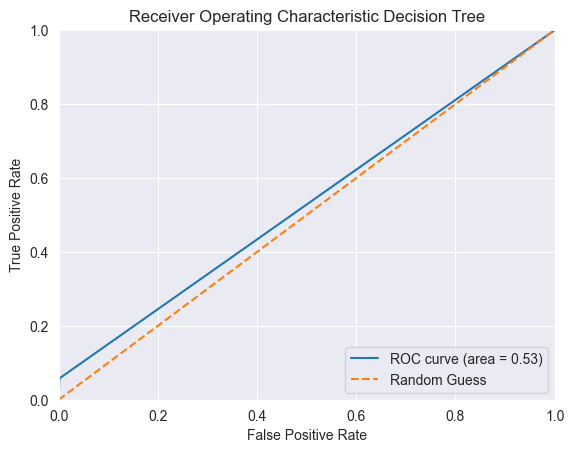

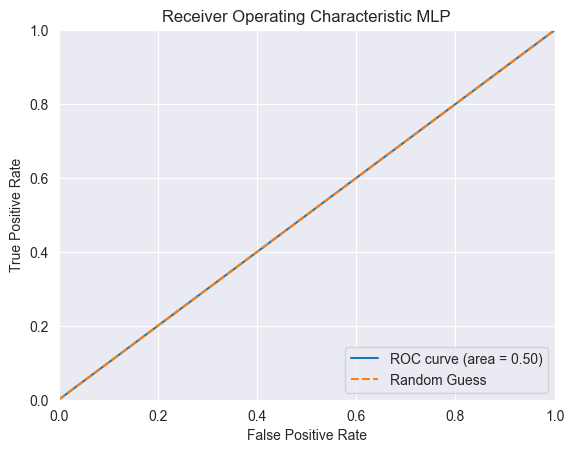

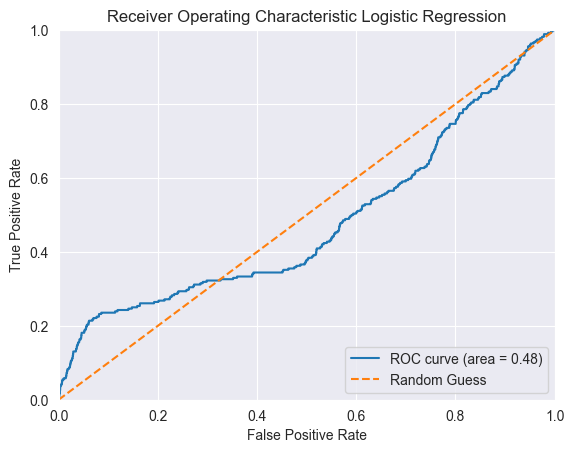

In [24]:
one_prob_dec_tree = [lst[1] for lst in y_proba_all_dec_tree]
fpr, tpr, thresholds = roc_curve(y_truth_all_dec_tree, one_prob_dec_tree)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Decision Tree')
plt.legend(loc="lower right")
plt.show()

one_prob_mlp = [lst[1] for lst in y_proba_all_mlp]
fpr, tpr, thresholds = roc_curve(y_truth_all_mlp, one_prob_mlp)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic MLP')
plt.legend(loc="lower right")
plt.show()

one_prob_log = [lst[1] for lst in y_proba_all_log]
fpr, tpr, thresholds = roc_curve(y_truth_all_log, one_prob_log)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Logistic Regression')
plt.legend(loc="lower right")
plt.show()